# Praca domowa nr 3

---

### Analiza wybranych forum Stack Exchange:

* matematyka        
* fizyka  
* elektronika 
* polityka
* filozofia
* historia
* judaizm
* chrzescijanstwo
* islam

---

### Generacja słownika `tab[<forum>][<tabela>]`

In [3]:
import os

rootdir = os.getcwd()

tables = ["Users","Badges","Posts","PostHistory","PostLinks","Comments","Tags","Votes"]
tables = [tables[0], tables[2], tables[5], tables[7]] # używane. potrzebne

group1 = ["islam", "christianity", "judaism"]
group2 = ["history", "philosophy", "politics"]
group3 = ["electronics", "physics", "math"]
groups = [[*["Religion"]*3, *["Humanities"]*3, *["Science"]*3]]

forums = [*group1, *group2, *group3]
tab = {}
for forum in forums:
    tab[forum] = {}
    for table in tables:
        csv_dir = os.path.join(rootdir, forum, forum+"_"+table+".csv")
        csv_dir = csv_dir.replace(" ", "_")
        tab[forum][table] = pd.read_csv(csv_dir, header=0, encoding='utf8',index_col=0)
        
        tab[forum][table] = tab[forum][table].loc[:, ~tab[forum][table].columns.str.startswith('Unnamed: ')].reset_index()
        print(forum + "_" + table + " done")

islam_Users done
islam_Posts done
islam_Comments done
islam_Votes done
christianity_Users done
christianity_Posts done
christianity_Comments done
christianity_Votes done
judaism_Users done
judaism_Posts done
judaism_Comments done
judaism_Votes done
history_Users done
history_Posts done
history_Comments done
history_Votes done
philosophy_Users done
philosophy_Posts done
philosophy_Comments done
philosophy_Votes done
politics_Users done
politics_Posts done
politics_Comments done
politics_Votes done
electronics_Users done
electronics_Posts done
electronics_Comments done


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


electronics_Votes done
physics_Users done
physics_Posts done
physics_Comments done
physics_Votes done
math_Users done
math_Posts done
math_Comments done
math_Votes done


---

## Prezentacja wyników

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use("seaborn-darkgrid")
sns.set_context("poster", font_scale=0.8)

---

### 1. Najbardziej kontrowersyjne posty - głosów na "nie" więcej od połowy głosów na "tak"

In [124]:
def query1(posts, votes):
    up_votes = votes.query("VoteTypeId == 2").groupby("PostId").size().rename("up_votes")
    down_votes = votes.query("VoteTypeId == 3").groupby("PostId").size().rename("down_votes")
    vot = down_votes.to_frame().join(up_votes).fillna(0)
    a = vot.shape[0]
    vot = vot.query("down_votes >= 0.5*up_votes")
    vot.loc[:, "difference"] = vot.loc[:, "down_votes"] - vot.loc[:, "up_votes"]
    result = posts.loc[:, ["Body", "Title", "Id"]].merge(vot, left_on="Id", right_on="PostId", how="inner") 
    return (result.shape[0]/posts.shape[0], result.shape[0]/a) # stosunek kontrowersyjnych do wszystkich, stosunek kontrowersyjnych do ocenionych

In [125]:
d1 = {}
values1 = []
values2 = []
for forum in forums:
    a, b = query1(tab[forum]["Posts"], tab[forum]["Votes"])
    values1.append(a)
    values2.append(b)
d1["Forum name"] = forums
d1["Controversial to all ratio"] = values1
d1["Controversial to evaluated ratio"] = values2
d1["Group"] = values3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [126]:
a1 = pd.DataFrame(data=d1)

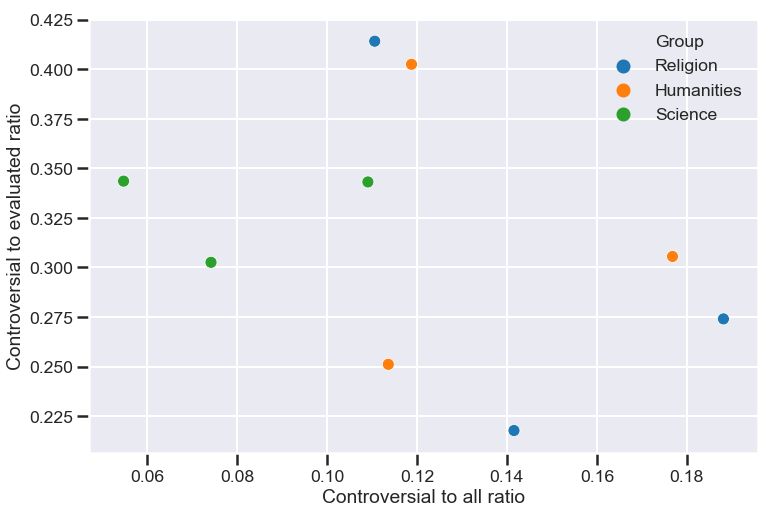

In [127]:
sns.scatterplot(data=a1, x=a1.columns.values[1], y=a1.columns.values[2], hue="Group")
plt.grid(linewidth=2)
plt.show()

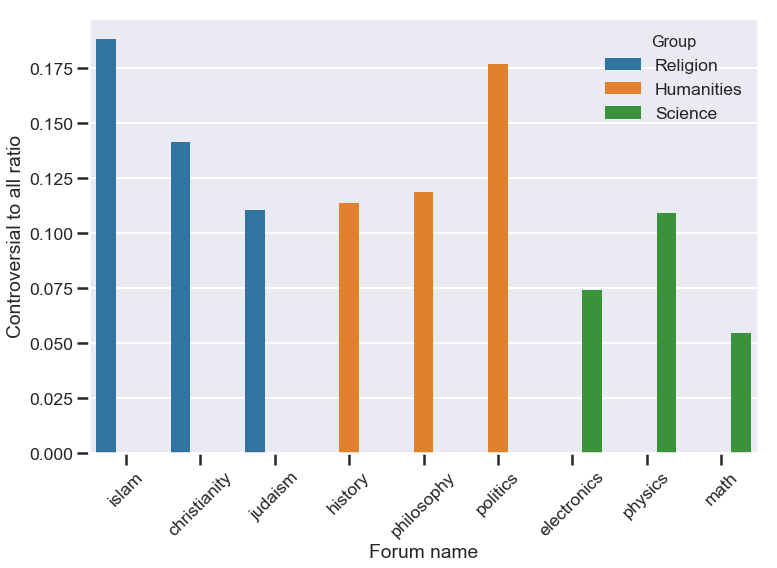

In [129]:
sns.barplot(data=a1, x=a1.columns.values[0], y=a1.columns.values[1], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

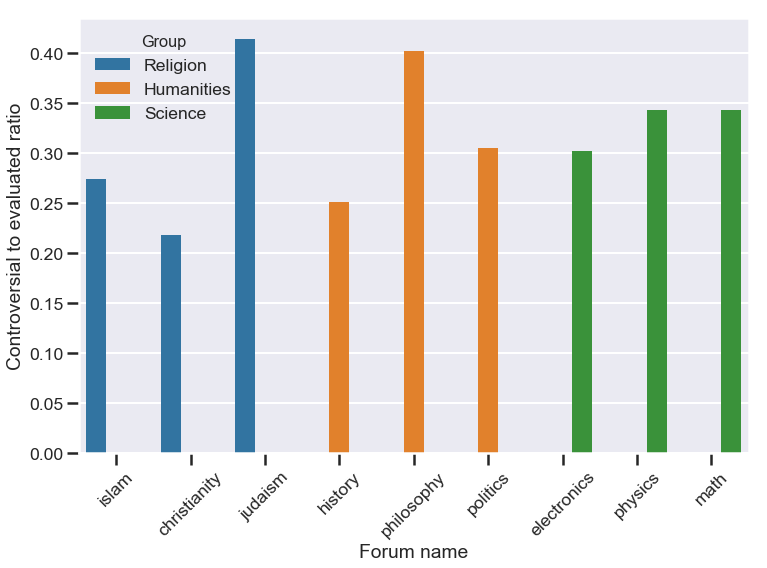

In [130]:
sns.barplot(data=a1, x=a1.columns.values[0], y=a1.columns.values[2], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

---

### 2. Różnica między najlepiej ocenioną odpowiedzią, a zaakceptowaną odpowiedzią większa od oceny zaakceptowanej odpowiedzi

In [131]:
def query2(posts):
    BestAnswers = posts.reindex(posts.query("PostTypeId==2").groupby("ParentId")["Score"].idxmax()).loc[:, ["ParentId", "Score"]]. \
        rename(columns={"Score": "MaxScore"})
    Questions = posts.query("PostTypeId==1")
    result1 = Questions.merge(BestAnswers, left_on="Id", right_on="ParentId", how="inner")
    result2 = result1.merge(posts, left_on="AcceptedAnswerId", right_on="Id", how="inner").rename( \
        columns={"Score_y": "AcceptedScore", "Id_x": "Id", "Title_x": "Title"}).loc[:, ["Id", "Title", "MaxScore", "AcceptedScore"]]
    result2.loc[:, "Difference"] = result2.loc[:, "MaxScore"] - result2.loc[:, "AcceptedScore"]
    return (result2.query("Difference > AcceptedScore and Difference > 0").shape[0]/Questions.shape[0], \
            Questions.loc[Questions.AcceptedAnswerId.notnull()].shape[0]/Questions.shape[0])

In [132]:
d2 = {}
values1 = []
values2 = []
values3 = [*["Religion"]*3, *["Humanities"]*3, *["Science"]*3]
for forum in forums:
    a, b = query2(tab[forum]["Posts"])
    values1.append(a)
    values2.append(b)
d2["Forum name"] = forums
d2["Questions having accepted answer to all ratio"] = values2
d2["Questions with big difference max-accepted to all ratio"] = values1
d2["Group"] = values3

In [133]:
a2 = pd.DataFrame(data=d2)

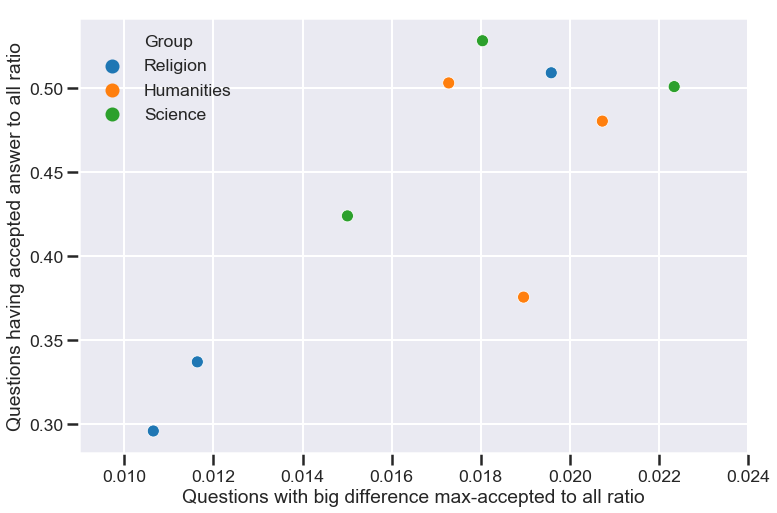

In [135]:
sns.scatterplot(data=a2, x=a2.columns.values[2], y=a2.columns.values[1], hue="Group")
plt.grid(linewidth=2)
plt.show()

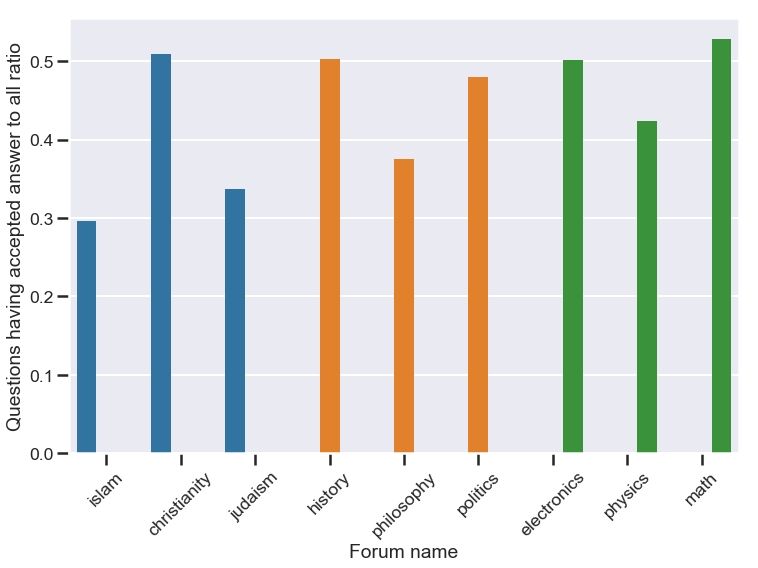

In [136]:
sns.barplot(data=a2, x=a2.columns.values[0], y=a2.columns.values[1], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.legend().set_visible(False)
plt.show()

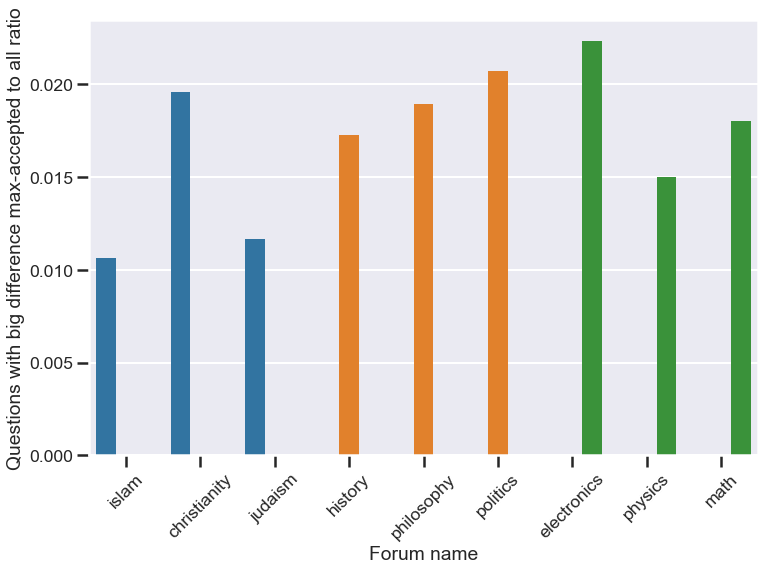

In [137]:
sns.barplot(data=a2, x=a2.columns.values[0], y=a2.columns.values[2], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.legend().set_visible(False)
plt.show()

---

### 3. Posty - średnia liczba odpowiedzi, ile pytań ma odpowiedź, ile pytań ma jakąś odpowiedź

In [138]:
def query3(posts):
    BestAnswers = posts.query("PostTypeId==2").groupby("ParentId").size().rename("NumberOfAnswers")
    Questions = posts.query("PostTypeId==1").join(BestAnswers)
    return(Questions.loc[:, "AnswerCount"].mean(), \
    Questions.query("AnswerCount != 0").shape[0]/Questions.shape[0])

In [139]:
d3 = {}
values1 = []
values2 = []
values3 = [*["Religion"]*3, *["Humanities"]*3, *["Science"]*3]
for forum in forums:
    a, b = query3(tab[forum]["Posts"])
    values1.append(a)
    values2.append(b)
d3["Forum name"] = forums
d3["Mean number of answers"] = values1
d3["Questions having any answer to all ratio"] = values2
d3["Group"] = values3

In [140]:
a3 = pd.DataFrame(data=d3)

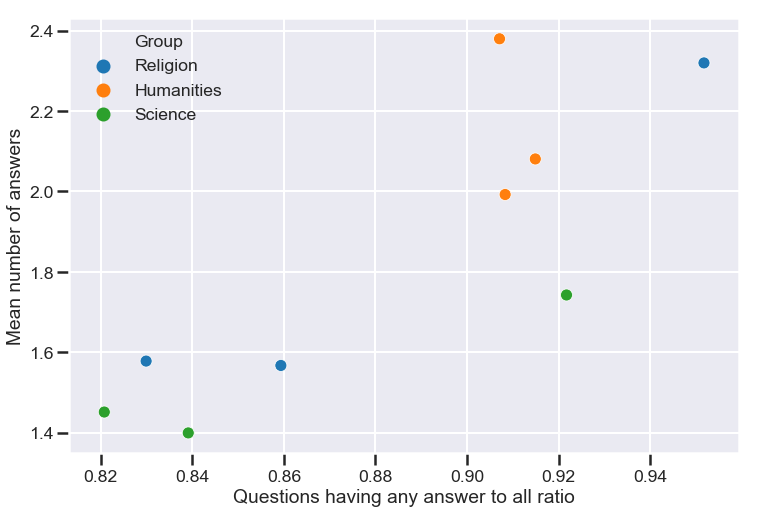

In [141]:
sns.scatterplot(data=a3, x=a3.columns.values[2], y=a3.columns.values[1], hue="Group")
plt.grid(linewidth=2)
plt.show()

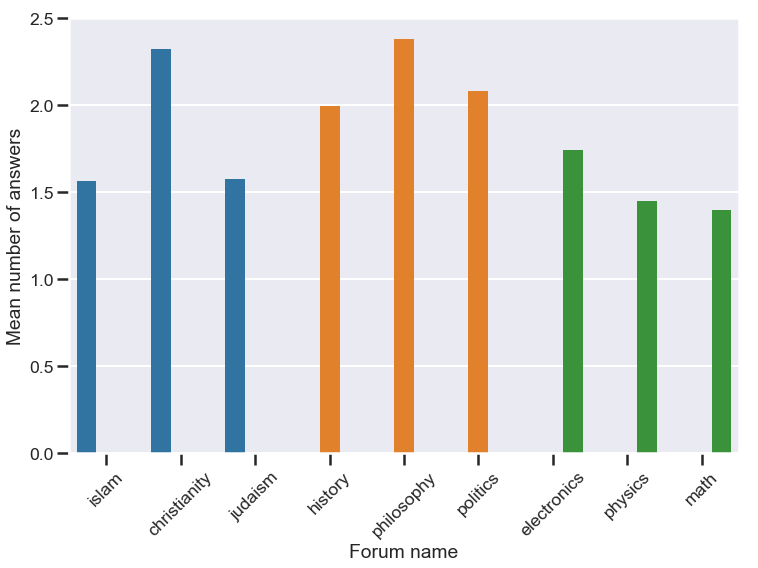

In [142]:
sns.barplot(data=a3, x=a3.columns.values[0], y=a3.columns.values[1], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.legend().set_visible(False)
plt.show()

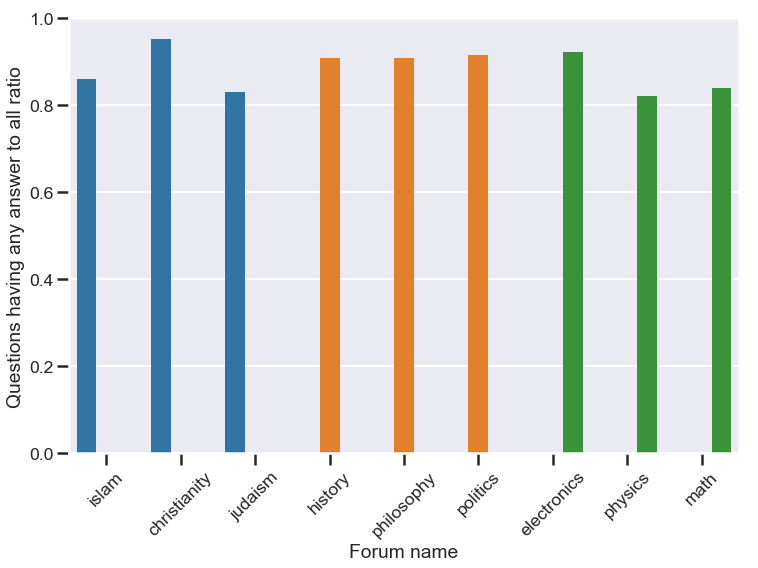

In [52]:
sns.barplot(data=a3, x=a3.columns.values[0], y=a3.columns.values[2], hue="Group")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.legend().set_visible(False)
plt.show()

---

In [6]:
# dla zapewnieniea zgodności kodu
beliefs = {"islam": tab["islam"], "christianity": tab["christianity"], "judaism": tab["judaism"]}
humanist = {"history": tab["history"], "philosophy": tab["philosophy"], "politics": tab["politics"]}
science = {"electronics": tab["electronics"], "physics": tab["physics"], "math": tab["math"]}

---

### 4. Próbujemy dowiedzieć się czegoś o użytkownikach, ale niestety jedyne co można sprawdzic to miejsce zamieszkania

In [144]:
location_dict = {}
for key, elem in beliefs.items():
    location_dict[key] = elem['Users'].groupby(['Location']).size().rename("Count").reset_index().sort_values(by='Count',ascending=False).head(5)
    
location_dict['christianity']

,Location,Count
2573,United States,283
1079,India,96
2570,United Kingdom,82
2550,USA,80
435,Canada,66


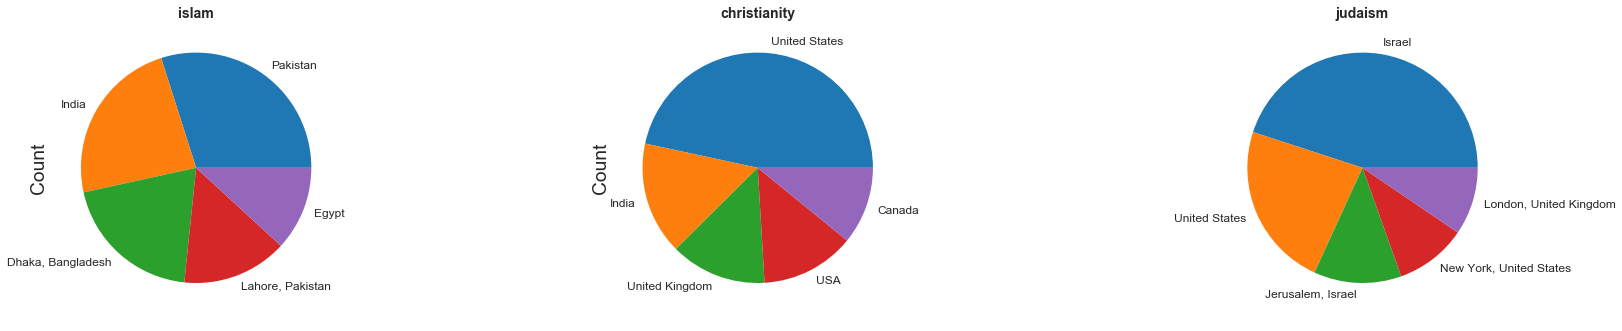

In [145]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax2 = fig.add_axes([0.65, .0, .5, .5], aspect=1)
ax3 = fig.add_axes([1.35, .0, .5, .5], aspect=1)

axes = []

axes.append(ax1)
axes.append(ax2)
axes.append(ax3)

i=0

for key, elem in location_dict.items():
    axes[i].set_title(key, weight='bold', size=14)
    plot = elem.plot(kind='pie',y='Count',labels=elem['Location'],legend=False,startangle=0,fontsize=12,ax=axes[i])
    pylab.ylabel('')
    i=i+1
    
plt.show()

---

### 5.1 Tym razem porównujemy posty: najpierw sprawdzimy, jakie tagi mają posty które otrzymują odpowiedzi najszybciej

In [146]:
# tutaj byc moze mozna uzyc iterowania po slownikach i podmieniac tylko nazwe <history> a reszta będzie taka sama

posts_and_comments = pd.merge(humanist['history']['Posts'][['Id','Title','Tags','Score','CreationDate']],humanist['history']['Comments'][['PostId','CreationDate']],left_on='Id',right_on='PostId').rename(columns={'CreationDate_x' : 'PostCreationDate','CreationDate_y':'CommentCreationDate'}).drop('PostId',axis=1)
posts_and_comments['PostCreationDate'] = pd.to_datetime(posts_and_comments['PostCreationDate'],format='%Y-%m-%d %H:%M')
posts_and_comments['CommentCreationDate'] = pd.to_datetime(posts_and_comments['CommentCreationDate'],format='%Y-%m-%d %H:%M')
posts_and_comments

,Id,Title,Tags,Score,PostCreationDate,CommentCreationDate
0,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2011-10-11 19:34:45.767
1,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2011-10-11 19:35:27.270
2,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2011-10-11 19:36:36.070
3,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2011-10-11 20:12:24.243
4,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2011-10-12 06:55:24.913
5,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2012-04-27 14:50:42.790
6,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2012-05-16 15:25:07.287
7,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,2011-10-11 19:30:14.017,2012-05-16 15:26:41.200
8,2,What language(s) were spoken within the Holy R...,<holy-roman-empire><language>,32,2011-10-11 19:31:39.163,2011-10-25 20:39:48.323
9,2,What language(s) were spoken within the Holy R...,<holy-roman-empire><language>,32,2011-10-11 19:31:39.163,2011-10-26 06:38:50.977


Dodatkowa kolumna obliczająca różnicę czasu pomiędzy pojawieniem się posta a pierwszym komentarzem 

In [147]:
# zostawienie tylko pierwszego komentarza
posts_and_comments = posts_and_comments.groupby('Id').first().reset_index()

# roznica czasu obliczana w minutach, zero miejsc po przecinku zeby nie bylo zbyt duzej roznorodnosci
posts_and_comments['TimeDifference'] = (posts_and_comments.CommentCreationDate - posts_and_comments.PostCreationDate)/ np.timedelta64(60,'m')
posts_and_comments['TimeDifference'] = np.round(posts_and_comments['TimeDifference'], decimals=0)
posts_and_comments = posts_and_comments.sort_values(by='TimeDifference')

In [148]:
posts_and_comments.groupby(['TimeDifference','Tags']).size().rename('Popularity').reset_index().sort_values(by=['Popularity','TimeDifference'],ascending=[False,True])

,TimeDifference,Tags,Popularity
1928,0.0,<world-war-two>,30
1606,0.0,<united-states>,25
3443,1.0,<world-war-two>,18
999,0.0,<middle-ages>,14
1127,0.0,<military>,12
3214,1.0,<united-states>,12
205,0.0,<ancient-history>,11
1816,0.0,<war>,11
2884,1.0,<military>,11
1904,0.0,<world-war-one>,10


Można to porównać z najpopularniejszymi tagami

In [149]:
most_popular_tags = humanist['history']['Posts'].groupby(['Tags']).size().rename('TagsPopularity').reset_index().sort_values(by='TagsPopularity',ascending=False)
most_popular_tags

,Tags,TagsPopularity
6916,<world-war-two>,92
5740,<united-states>,68
827,<ancient-history>,44
4057,<military>,41
1225,<ancient-rome>,39
6830,<world-war-one>,37
3612,<middle-ages>,36
2962,<historiography>,28
662,<american-civil-war>,26
6549,<war>,24


---

### 5.2 O jakich porach dnia posty najszybciej otrzymują odpowiedź?

In [150]:
# czas stworzenia postu i komentarza zamieniono na samą godzinę, jednak kolumna TimeDifference pozostaje niezmieniona

posts_and_comments_2 = posts_and_comments.copy()

from datetime import datetime

posts_and_comments_2['PostCreationDate'] = pd.to_datetime(posts_and_comments_2['PostCreationDate'],format='%H:%M:%S').dt.hour
posts_and_comments_2['CommentCreationDate'] = pd.to_datetime(posts_and_comments_2['CommentCreationDate'],format='%H:%M:%S').dt.hour
posts_and_comments_2.head(5)


,Id,Title,Tags,Score,PostCreationDate,CommentCreationDate,TimeDifference
1375,2168,Based on historical experience what would happ...,<united-states><europe><economy><political-his...,4,21,18,-3.0
0,1,What factors related to the Eastern Crisis con...,<20th-century><world-war-one>,17,19,19,0.0
10359,27332,NaN,NaN,8,22,23,0.0
10358,27331,NaN,NaN,5,22,22,0.0
10354,27310,NaN,NaN,-1,14,14,0.0


In [151]:
# O jakiej godzinie w ciągu dnia pojawia się najwięcej "szybkich odpowiedzi na post"
# czyli takich, które gdzie pierwszy komentarz pojawił się po maksymalnie godzinie

posts_and_comments_2 = posts_and_comments_2.query('TimeDifference in (0.0,0.1)').groupby('PostCreationDate').size().rename('Count').reset_index().sort_values(by='PostCreationDate')
posts_and_comments_2 = posts_and_comments_2.rename({"PostCreationDate" : "PostCreationHour"})

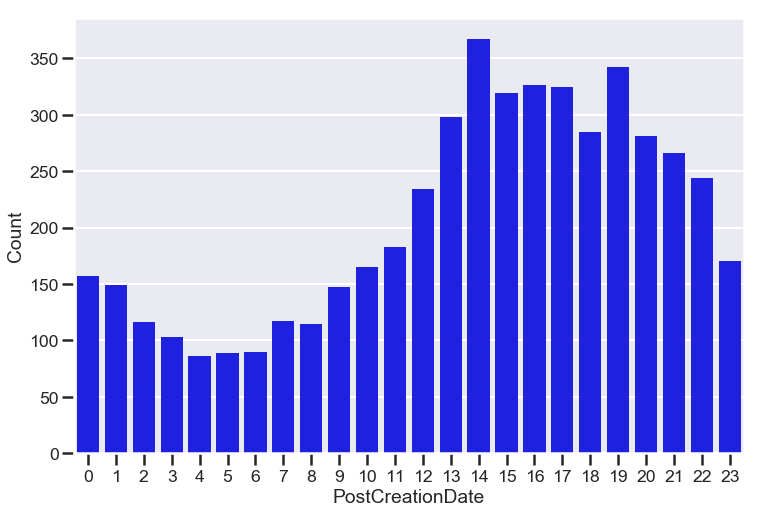

In [152]:
import seaborn as sns

# wykres dla pojedynczego forum 

ax = sns.barplot(x=posts_and_comments_2.PostCreationDate,y=posts_and_comments_2.Count,color="blue")
plt.show()

In [154]:
from datetime import datetime

# przygotowanie słownika dataframe'ów dla wszystkich forum
fastAnswers_dict = {}

for key, elem in humanist.items():
    posts_and_comments = pd.merge(elem['Posts'][['Id','Title','Tags','Score','CreationDate']],elem['Comments'][['PostId','CreationDate']],left_on='Id',right_on='PostId').rename(columns={'CreationDate_x' : 'PostCreation','CreationDate_y':'CommentCreation'}).drop('PostId',axis=1)
    posts_and_comments['PostCreation'] = pd.to_datetime(posts_and_comments['PostCreation'],format='%Y-%m-%d %H:%M')
    posts_and_comments['CommentCreation'] = pd.to_datetime(posts_and_comments['CommentCreation'],format='%Y-%m-%d %H:%M')

    # zostawienie tylko pierwszego komentarza
    posts_and_comments = posts_and_comments.groupby('Id').first().reset_index()

    # roznica czasu obliczana w minutach, zero miejsc po przecinku zeby nie bylo zbyt duzej roznorodnosci
    posts_and_comments['TimeDifference'] = (posts_and_comments.CommentCreation - posts_and_comments.PostCreation)/ np.timedelta64(60,'m')
    posts_and_comments['TimeDifference'] = np.round(posts_and_comments['TimeDifference'], decimals=0)
    posts_and_comments = posts_and_comments.sort_values(by='TimeDifference')
    
    posts_and_comments_2 = posts_and_comments.copy()
    
    posts_and_comments_2['PostCreation'] = pd.to_datetime(posts_and_comments_2['PostCreation']).dt.hour
    posts_and_comments_2['CommentCreation'] = pd.to_datetime(posts_and_comments_2['CommentCreation']).dt.hour

    posts_and_comments_2 = posts_and_comments_2.query('TimeDifference in (0.0,0.1)').groupby('PostCreation').size().rename('Count').reset_index().sort_values(by='PostCreation')
    fastAnswers_dict[key] = posts_and_comments_2


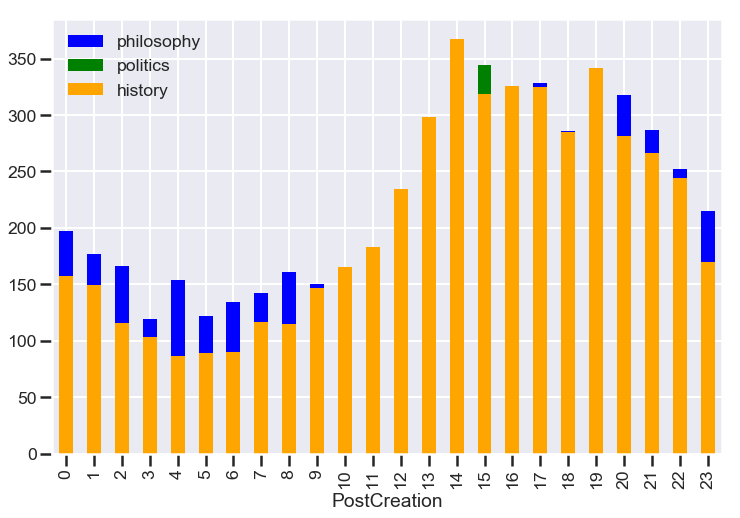

In [156]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

fastAnswers_dict['philosophy'].plot(x=0, y=1, kind="bar",ax=ax1,color='blue')
fastAnswers_dict['politics'].plot(x=0, y=1, kind="bar",ax=ax1,color='green')
fastAnswers_dict['history'].plot(x=0, y=1, kind="bar",ax=ax1,color='orange')

ax1.legend(["philosophy", "politics","history"]);

plt.show()

---

### 6. Które forum rozrastało się najszybciej?

In [7]:
history = tab["history"]

In [8]:
posts_creationDate = history['Posts'][['Id','CreationDate']].reset_index(drop=True)
posts_creationDate['CreationDate'] = pd.to_datetime(posts_creationDate['CreationDate'])
posts_creationDate['CreationDate'] = posts_creationDate.CreationDate.dt.to_period('M')
posts_creationDate = posts_creationDate.groupby('CreationDate').size().rename('NumberOfPostsPerMonth').reset_index()

In [10]:
forumGrowth_dict = {}
for key, elem in humanist.items():
    posts_creationDate = elem['Posts']['CreationDate'].reset_index()
    posts_creationDate['CreationDate'] = pd.to_datetime(posts_creationDate['CreationDate'])
    posts_creationDate['CreationDate'] = posts_creationDate.CreationDate.dt.to_period('M')
    forumGrowth_dict[key] = posts_creationDate.groupby('CreationDate').size().rename('NumberOfPostsPerMonth').reset_index().iloc[:-2, :]


In [12]:
for key, elem in beliefs.items():
    posts_creationDate = elem['Posts']['CreationDate'].reset_index()
    posts_creationDate['CreationDate'] = pd.to_datetime(posts_creationDate['CreationDate'])
    posts_creationDate['CreationDate'] = posts_creationDate.CreationDate.dt.to_period('M')
    forumGrowth_dict[key] = posts_creationDate.groupby('CreationDate').size().rename('NumberOfPostsPerMonth').reset_index().iloc[:-2, :]

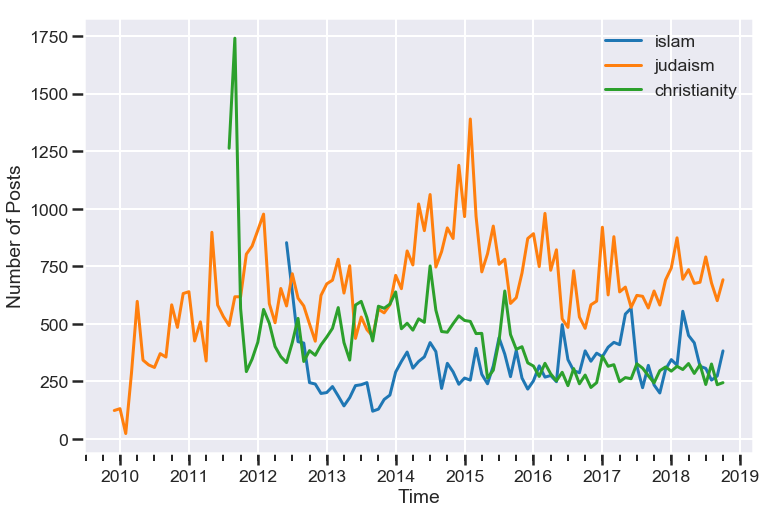

In [13]:
ax = forumGrowth_dict['islam'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="islam")
forumGrowth_dict['judaism'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="judaism",ax=ax)
forumGrowth_dict['christianity'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="christianity",ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Posts")
plt.show()

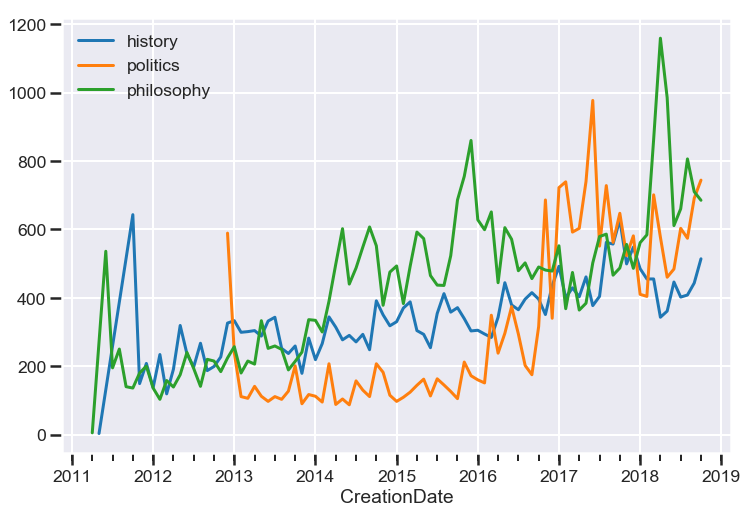

In [14]:
ax = forumGrowth_dict['history'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="history")
forumGrowth_dict['politics'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="politics",ax=ax)
forumGrowth_dict['philosophy'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="philosophy",ax=ax)
plt.show()

In [15]:
for key, elem in science.items():
    posts_creationDate = elem['Posts']['CreationDate'].reset_index()
    posts_creationDate['CreationDate'] = pd.to_datetime(posts_creationDate['CreationDate'])
    posts_creationDate['CreationDate'] = posts_creationDate.CreationDate.dt.to_period('M')
    forumGrowth_dict[key] = posts_creationDate.groupby('CreationDate').size().rename('NumberOfPostsPerMonth').reset_index().iloc[:-2, :]

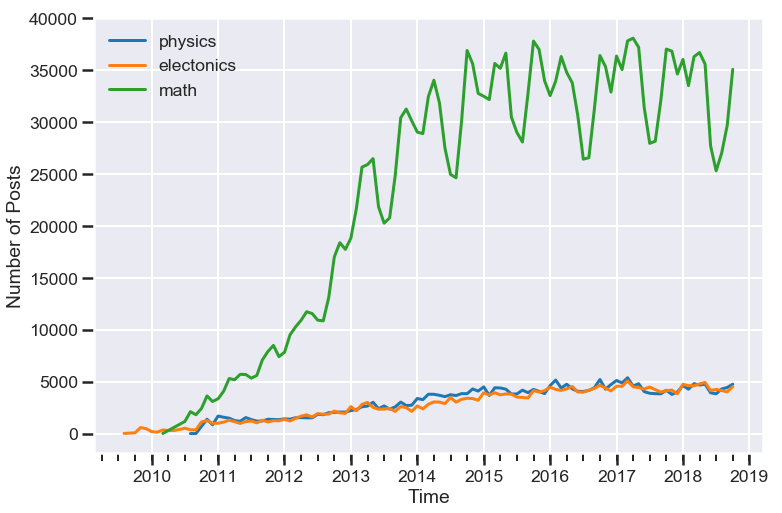

In [16]:
ax = forumGrowth_dict['physics'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="physics")
forumGrowth_dict['electronics'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="electonics",ax=ax)
forumGrowth_dict['math'].plot(x='CreationDate', y='NumberOfPostsPerMonth', marker='',label="math",ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Posts")
plt.show()

---

### 7. Ile było komentarzy/odpowiedzi na dany wątek - czy są długie dyskusje?

In [17]:
commentCount_dict = {}
for key, elem in humanist.items():
    commentCount_dict[key] = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()['CommentCount'].mean()
for key, elem in beliefs.items():
    commentCount_dict[key] = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()['CommentCount'].mean()  
for key, elem in science.items():
    commentCount_dict[key] = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()['CommentCount'].mean()  

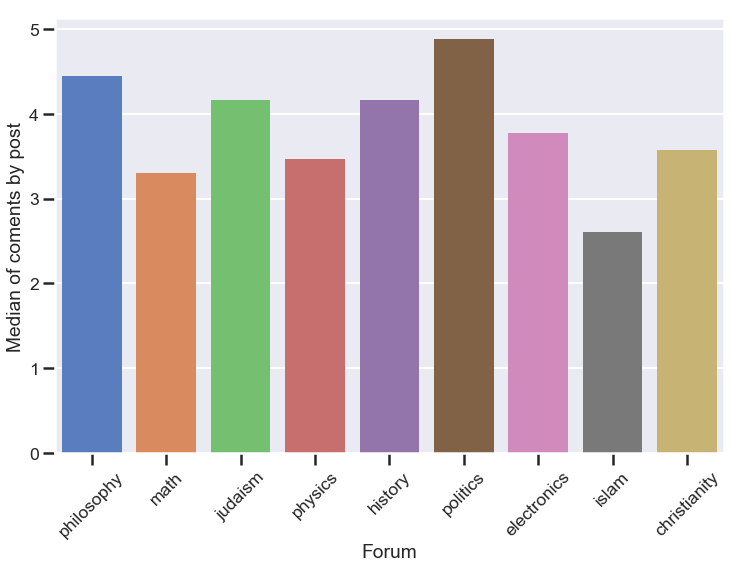

In [21]:
keys = list(set(commentCount_dict.keys()))
vals = [commentCount_dict[i] for i in keys]

ax = sns.barplot(x=keys,y=vals,palette="muted")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
ax.set_xlabel("Forum")
ax.set_ylabel("Median of coments by post")
plt.show()

In [117]:
forums = []
comments_count_short = []
comments_count_long = []



for key,elem in humanist.items():
    comments_count = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()
    comments_count_short.append(comments_count.loc[(comments_count.CommentCount<4),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    comments_count_long.append(comments_count.loc[(comments_count.CommentCount>3),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    forums.append(key)

for key,elem in beliefs.items():
    comments_count = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()
    comments_count_short.append(comments_count.loc[(comments_count.CommentCount<4),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    comments_count_long.append(comments_count.loc[(comments_count.CommentCount>3),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    forums.append(key)

for key,elem in science.items():
    comments_count = elem['Comments'].groupby('PostId').size().rename('CommentCount').reset_index()
    comments_count_short.append(comments_count.loc[(comments_count.CommentCount<4),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    comments_count_long.append(comments_count.loc[(comments_count.CommentCount>3),['PostId','CommentCount']].reset_index(drop=True)['CommentCount'].count())
    forums.append(key)
    
df = pd.DataFrame({'ForumName': forums,
                   'ShortDiscussions': comments_count_short,
                   'LongDiscussions' :  comments_count_long })



In [118]:
df

,ForumName,ShortDiscussions,LongDiscussions
0,history,11209,9151
1,philosophy,12740,10469
2,politics,8005,8133
3,islam,9830,2872
4,christianity,14312,8316
5,judaism,27108,21692
6,electronics,114485,75312
7,physics,118199,64865
8,math,903751,449783


In [119]:
a = {}
df = df.set_index("ForumName")

In [120]:
for forum in df.index:
    a[forum] = df.loc[forum, ["ShortDiscussions", "LongDiscussions"]]
    
df1=pd.DataFrame(data=a)
df1

,history,philosophy,politics,islam,christianity,judaism,electronics,physics,math
ShortDiscussions,11209,12740,8005,9830,14312,27108,114485,118199,903751
LongDiscussions,9151,10469,8133,2872,8316,21692,75312,64865,449783


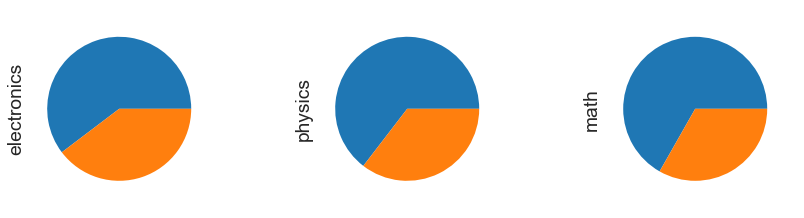

In [134]:
#import pylab
fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax2 = fig.add_axes([0.8, .0, .5, .5], aspect=1)
ax3 = fig.add_axes([1.6, .0, .5, .5], aspect=1)

axes = []

axes.append(ax1)
axes.append(ax2)
axes.append(ax3)

i=0

for column in df1.iloc[:,6:9]:
    #axes[i].set_title(column, weight='bold', size=14)
    plot = df1.plot.pie(y=column, figsize=(5, 5),ax=axes[i],legend=None,labels=None)
    #pylab.ylabel('')
    i=i+1
    
#axes[0].legend(labels=["ShortDiscussions","ShortDiscussions"], loc='lower right')
plt.show()

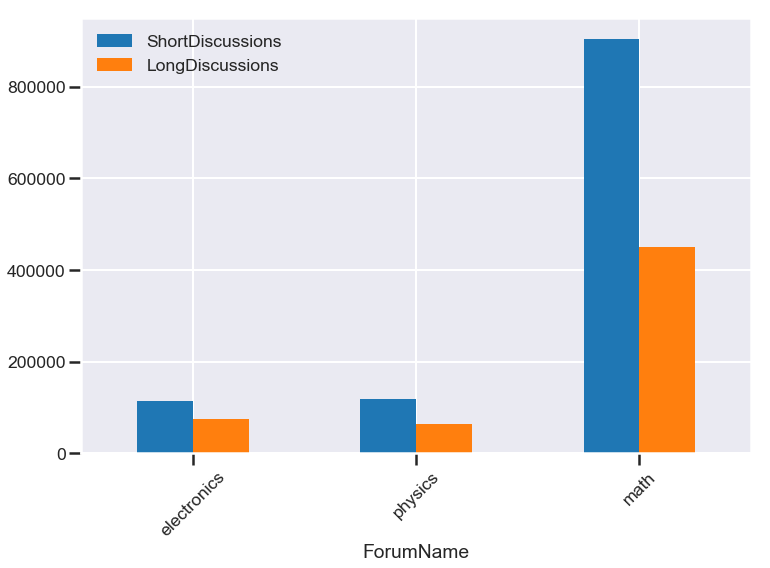

In [135]:
d_plot = df.reset_index().iloc[6:9, :].plot(x="ForumName", y=["ShortDiscussions","LongDiscussions"], kind="bar")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()